# Glaucoma Classification from Saved Segmentation Masks

This notebook loads predicted segmentation masks, extracts clinical features (CDR, vertical CDR, etc.), and performs glaucoma classification using a Random Forest. The workflow assumes your masks are saved in a folder (e.g., `masks/`) with filenames matching the image IDs.

Semi-annotation (CDR-thresh) Classification -- Accuracy: 1.0000, ROC-AUC: 1.0000, Optimal Threshold: 0.760


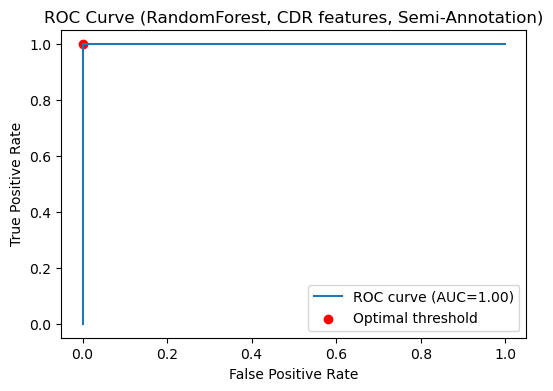

In [9]:
import os
import numpy as np
from scipy.io import loadmat
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# --- 1. Collect mask files and pseudo-labels from Semi-automatic-annotations ---
masks_dir = 'ORIGA/ORIGA/Semi-automatic-annotations'
mask_ext = '.mat'
mask_key = 'mask'

def extract_features(mask):
    # mask: np.array, 0=bg, 1=OD, 2=OC
    od = (mask == 1)
    oc = (mask == 2)
    od_area = np.sum(od)
    oc_area = np.sum(oc)
    rim_area = od_area - oc_area if od_area > oc_area else 0
    # vertical CDR: ratio of vertical extents
    od_rows = np.any(od, axis=1)
    oc_rows = np.any(oc, axis=1)
    od_height = np.ptp(np.where(od_rows)[0]) + 1 if np.any(od_rows) else 0
    oc_height = np.ptp(np.where(oc_rows)[0]) + 1 if np.any(oc_rows) else 0
    vertical_cdr = oc_height / od_height if od_height > 0 else 0.0
    # classic CDR area
    cdr_area = oc_area / od_area if od_area > 0 else 0.0
    return [cdr_area, vertical_cdr, od_area, oc_area, rim_area]

def pseudo_label_from_cdr(cdr, threshold=0.6):
    # You can adjust threshold. Default: 0.6 (common for glaucoma risk)
    return int(cdr > threshold)

features = []
pseudo_labels = []
mask_files = [f for f in os.listdir(masks_dir) if f.endswith(mask_ext)]
for fname in mask_files:
    mat = loadmat(os.path.join(masks_dir, fname))
    mask = mat[mask_key].astype(np.uint8)
    feats = extract_features(mask)
    features.append(feats)
    pseudo_labels.append(pseudo_label_from_cdr(feats[0]))  # feats[0] is cdr_area
features = np.array(features)
pseudo_labels = np.array(pseudo_labels)

# --- 2. Classification with Random Forest and ROC analysis ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_probs, all_trues = [], []
for train_idx, test_idx in skf.split(features, pseudo_labels):
    X_train, X_test = features[train_idx], features[test_idx]
    y_train, y_test = pseudo_labels[train_idx], pseudo_labels[test_idx]
    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)[:, 1]  # probability of positive class
    all_probs.extend(probs)
    all_trues.extend(y_test)
all_probs = np.array(all_probs)
all_trues = np.array(all_trues)

# --- 3. Compute optimal threshold and report ---
fpr, tpr, thresholds = roc_curve(all_trues, all_probs)
youden = tpr - fpr
optimal_idx = np.argmax(youden)
optimal_threshold = thresholds[optimal_idx]
y_pred_optimal = (all_probs >= optimal_threshold).astype(int)

acc = accuracy_score(all_trues, y_pred_optimal)
auc = roc_auc_score(all_trues, all_probs)
print(f'Semi-annotation (CDR-thresh) Classification -- Accuracy: {acc:.4f}, ROC-AUC: {auc:.4f}, Optimal Threshold: {optimal_threshold:.3f}')

# --- 4. Plot ROC curve ---
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC={auc:.2f})')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label='Optimal threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (RandomForest, CDR features, Semi-Annotation)')
plt.legend()
plt.show()